In [ ]:
# ==============================================================================
# PART 1: SETUP AND IMPORTS
# ==============================================================================
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np

# This code connects your Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ==============================================================================
# PART 2: CONFIGURATION AND DATA LOADING
# ==============================================================================
# MobileNetV2 is optimized for 224x224 images
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 16 # A slightly larger batch size can be more efficient

# --- IMPORTANT: Double-check these paths to your dataset ---
train_dir = "/content/drive/MyDrive/kitchen-items/training_dataset"
test_dir = "/content/drive/MyDrive/kitchen-items/testing_dataset"

# Load the datasets from your folders
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

# Get class names and the number of classes
class_names = train_dataset.class_names
num_classes = len(class_names)
print("Found the following classes:", class_names)



Found 104 files belonging to 3 classes.
Found 27 files belonging to 3 classes.
Found the following classes: ['Knife', 'Scissors', 'Spoon']


In [ ]:
# ==============================================================================
# PART 3: BUILD THE HIGH-ACCURACY TRANSFER LEARNING MODEL
# ==============================================================================

# --- Step A: Define a single, more powerful Data Augmentation layer ---
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.1),
], name="data_augmentation")

# --- Step B: Load the pre-trained "expert" base model (MobileNetV2) ---
base_model = MobileNetV2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,  # We don't need its final classification layer
    weights='imagenet'  # Use weights pre-trained on millions of images
)

# --- Step C: Freeze the expert's brain so we don't ruin its knowledge ---
base_model.trainable = False

# --- Step D: Build our new model by adding our own layers on top ---
inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
# 1. Apply data augmentation
x = data_augmentation(inputs)
# 2. Apply the special preprocessing required by MobileNetV2
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
# 3. Pass data through the frozen expert
x = base_model(x, training=False)
# 4. Add our own custom "head" for making decisions
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)  # Dropout helps prevent overfitting
# 5. The final decision layer with units matching our number of classes
outputs = layers.Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs, outputs)

# Let's see the structure of our new model
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │         3,843 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,261,827 (8.63 MB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# ==============================================================================
# PART 4: COMPILE AND TRAIN THE MODEL
# ==============================================================================
# It's best to use a slightly lower learning rate for transfer learning
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# We'll still use EarlyStopping to find the best number of epochs automatically
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Train the model
print("\n--- Starting Model Training ---")
history = model.fit(
    train_dataset,
    epochs=25,  # Set a high number; EarlyStopping will stop it at the best time
    validation_data=test_dataset,
    callbacks=[early_stopping]
)


--- Starting Model Training ---
Epoch 1/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 81s 11s/step - accuracy: 0.5428 - loss: 0.9863 - val_accuracy: 0.9259 - val_loss: 0.4718
Epoch 2/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.9445 - loss: 0.3655 - val_accuracy: 1.0000 - val_loss: 0.1524
Epoch 3/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.9647 - loss: 0.1447 - val_accuracy: 1.0000 - val_loss: 0.0614
Epoch 4/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 1.0000 - loss: 0.0601 - val_accuracy: 1.0000 - val_loss: 0.0375
Epoch 5/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.9928 - loss: 0.0409 - val_accuracy: 1.0000 - val_loss: 0.0258
Epoch 6/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - accuracy: 1.0000 - loss: 0.0326 - val_accuracy: 1.0000 - val_loss: 0.0192
Epoch 7/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 1.0000 - loss: 0.0288 - val_accuracy: 1.0000 - val_loss: 0.0159
Epoch 8/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 50s 4s/step - accuracy: 1.0000 - loss: 0.0236 - val_accuracy: 

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 829ms/step - accuracy: 1.0000 - loss: 0.0057

Final Test Accuracy: 100.00%

--- Predicting on new image: /content/Screenshot 2025-08-21 173926.png ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


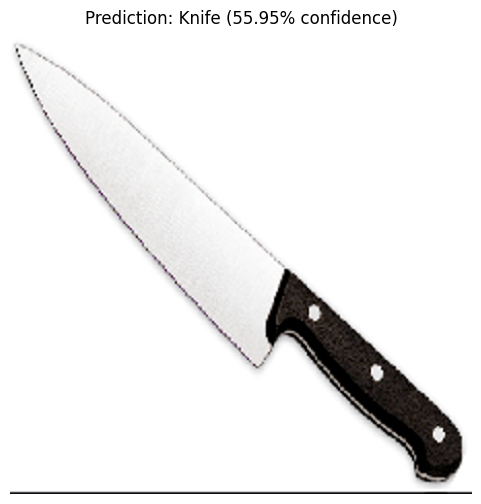


Full prediction scores:
Knife: 95.49%
Scissors: 1.92%
Spoon: 2.59%


In [ ]:
# ==============================================================================
# PART 5: EVALUATE AND TEST THE NEW MODEL
# ==============================================================================
# Evaluate the final model on the test data
loss, accuracy = model.evaluate(test_dataset)
print(f"\nFinal Test Accuracy: {accuracy * 100:.2f}%")

# --- Make a prediction on a new image ---
# --- IMPORTANT: Change this path to an image you want to test ---
image_path = '/content/Screenshot 2025-08-21 173926.png'

print(f"\n--- Predicting on new image: {image_path} ---")
img = tf.keras.utils.load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

# Make the prediction
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

# Show the result
plt.figure(figsize=(6, 6))
plt.imshow(img.resize((int(img.width*2), int(img.height*2)))) # Show a bigger image
plt.title(f"Prediction: {class_names[np.argmax(score)]} ({100 * np.max(score):.2f}% confidence)")
plt.axis("off")
plt.show()

print("\nFull prediction scores:")
for i in range(len(class_names)):
    print(f"{class_names[i]}: {predictions[0][i]*100:.2f}%")

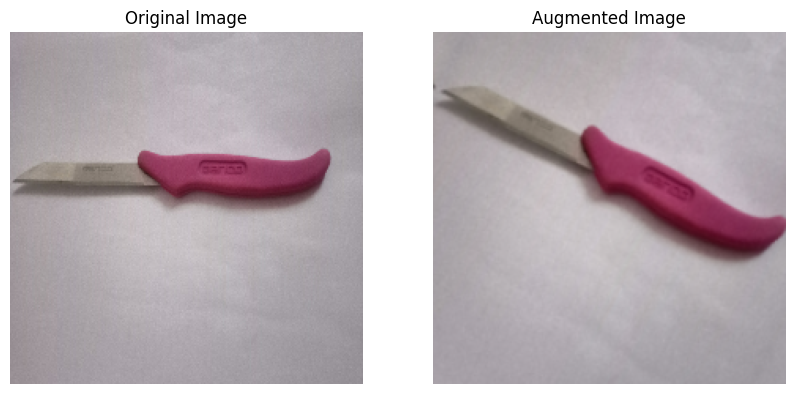

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf

# --- Get one batch of images to play with ---
for images, labels in train_dataset.take(1):
  # Let's just use the first image from the batch
  first_image = images[0]

  # Set up the same augmentation layer we used for the model
  data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),  # Increased from 0.1
    layers.RandomZoom(0.2),      # Increased from 0.1
    layers.RandomContrast(0.1),  # Add another type of augmentation
])


  # --- Display the original vs. augmented image ---
  plt.figure(figsize=(10, 5))

  # Original
  plt.subplot(1, 2, 1)
  plt.imshow(first_image / 255.0) # We divide by 255 to show it properly
  plt.title("Original Image")
  plt.axis("off")

  # Augmented
  # We need to add a "batch" dimension before passing it to the layer
  augmented_image = data_augmentation(tf.expand_dims(first_image, 0))

  plt.subplot(1, 2, 2)
  # The output of the layer is a batch, so we take the first item
  plt.imshow(augmented_image[0] / 255.0)
  plt.title("Augmented Image")
  plt.axis("off")

  plt.show()

In [ ]:
import os

# --- Create a directory to save the images ---
save_dir = "Saved_Augmented_Images"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Use the same augmentation layer
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),  # Increased from 0.1
    layers.RandomZoom(0.2),      # Increased from 0.1
    layers.RandomContrast(0.1),  # Add another type of augmentation
])


print(f"Generating and saving augmented images to '{save_dir}'...")

# --- Loop through your dataset and save augmented images ---
# We'll go through each original image in your training set
image_counter = 0
for original_images, original_labels in train_dataset.unbatch().take(75): # 75 is your total training images

    # For each original image, let's create 5 augmented versions
    for i in range(5):
        # Apply the augmentation
        augmented_image = data_augmentation(tf.expand_dims(original_images, 0))

        # Define the new filename
        new_filename = f"aug_{image_counter}_variant_{i+1}.png"
        save_path = os.path.join(save_dir, new_filename)

        # Save the image
        tf.keras.utils.save_img(save_path, augmented_image[0])

    image_counter += 1

print(f"Done! Saved {image_counter * 5} new images.")

Generating and saving augmented images to 'Saved_Augmented_Images'...
Done! Saved 375 new images.


In [ ]:
!zip -r /content/augmented_images.zip /content/Saved_Augmented_Images/

updating: content/Saved_Augmented_Images/ (stored 0%)
updating: content/Saved_Augmented_Images/aug_63_variant_5.png (deflated 0%)
updating: content/Saved_Augmented_Images/aug_73_variant_2.png (deflated 0%)
updating: content/Saved_Augmented_Images/aug_70_variant_3.png (deflated 0%)
updating: content/Saved_Augmented_Images/aug_37_variant_2.png (deflated 0%)
updating: content/Saved_Augmented_Images/aug_39_variant_4.png (deflated 0%)
updating: content/Saved_Augmented_Images/aug_45_variant_4.png (deflated 0%)
updating: content/Saved_Augmented_Images/aug_9_variant_4.png (deflated 0%)
updating: content/Saved_Augmented_Images/aug_1_variant_2.png (deflated 0%)
updating: content/Saved_Augmented_Images/aug_10_variant_1.png (deflated 0%)
updating: content/Saved_Augmented_Images/aug_54_variant_2.png (deflated 0%)
updating: content/Saved_Augmented_Images/aug_5_variant_3.png (deflated 0%)
updating: content/Saved_Augmented_Images/aug_29_variant_1.png (deflated 0%)
updating: content/Saved_Augmented_Ima